In [23]:
import re
from pathlib import Path
from tqdm.notebook import tqdm

For this I basically create the systems so I could read the topologies written by QligFEP

```shell
micromamba activate qligfep_new && cd bace && setupFEP -FF AMBER14sb -c DARDEL -r 25 -b auto --start 0.5 -R 10 -S sigmoidal -ts 2fs -clean dcd inp -j mapping.json -log info -rest kartograf -rs 42 && rm */*/inputfiles/*.inp && cd ../
micromamba activate qligfep_new && cd cdk2 && setupFEP -FF AMBER14sb -c SNELLIUS -r 25 -b auto --start 0.5 -R 10 -S sigmoidal -ts 2fs -clean dcd inp -j mapping.json -log info -rest kartograf -rs 42  && rm */*/inputfiles/*.inp && cd ../
micromamba activate qligfep_new && cd jnk1 && setupFEP -FF AMBER14sb -c DARDEL -r 25 -b auto --start 0.5 -R 10 -S sigmoidal -ts 2fs -clean dcd inp -j mapping.json -log info -rest kartograf -rs 42 && rm */*/inputfiles/*.inp && cd ../
micromamba activate qligfep_new && cd mcl1 && setupFEP -FF AMBER14sb -c DARDEL -r 25 -b auto --start 0.5 -R 10 -S sigmoidal -ts 2fs -clean dcd inp -j mapping.json -log info -rest kartograf -rs 42 && rm */*/inputfiles/*.inp && cd ../
micromamba activate qligfep_new && cd p38 && setupFEP -FF AMBER14sb -c DARDEL -r 25 -b auto --start 0.5 -R 10 -S sigmoidal -ts 2fs -clean dcd inp -j mapping.json -log info -rest kartograf -rs 42 && rm */*/inputfiles/*.inp && cd ../
micromamba activate qligfep_new && cd ptp1b && setupFEP -FF AMBER14sb -c SNELLIUS -r 25 -b auto --start 0.5 -R 10 -S sigmoidal -ts 2fs -clean dcd inp -j mapping.json -log info -rest kartograf -rs 42 && rm */*/inputfiles/*.inp && cd ../
micromamba activate qligfep_new && cd thrombin && setupFEP -FF AMBER14sb -c SNELLIUS -r 25 -b auto --start 0.5 -R 10 -S sigmoidal -ts 2fs -clean dcd inp -j mapping.json -log info -rest kartograf -rs 42 && rm */*/inputfiles/*.inp && cd ../
micromamba activate qligfep_new && cd tyk2 && setupFEP -FF AMBER14sb -c DARDEL -r 25 -b auto --start 0.5 -R 10 -S sigmoidal -ts 2fs -clean dcd inp -j mapping.json -log info -rest kartograf -rs 42 && rm */*/inputfiles/*.inp && cd ../
micromamba activate qligfep_new && cd cdk8ManualMapping && setupFEP -FF AMBER14sb -c SNELLIUS -r 25 -b auto --start 0.5 -R 10 -S sigmoidal -ts 2fs -clean dcd inp -j mapping.json -log info -rest kartograf -rs 42 && rm */*/inputfiles/*.inp && cd ../
micromamba activate qligfep_new && cd cmet && setupFEP -FF AMBER14sb -c DARDEL -r 25 -b auto --start 0.5 -R 10 -S sigmoidal -ts 2fs -clean dcd inp -j mapping.json -log info -rest heavyatom_ls -rs 42 && rm */*/inputfiles/*.inp && cd ../
micromamba activate qligfep_new && cd eg5 && setupFEP -FF AMBER14sb -c DARDEL -r 25 -b auto --start 0.5 -R 10 -S sigmoidal -ts 2fs -clean dcd inp -j mapping.json -log info -rest kartograf -rs 42 && rm */*/inputfiles/*.inp && cd ../
micromamba activate qligfep_new && cd hif2a && setupFEP -FF AMBER14sb -c DARDEL -r 25 -b auto --start 0.5 -R 10 -S sigmoidal -ts 2fs -clean dcd inp -j mapping.json -log info -rest kartograf -rs 42 && rm */*/inputfiles/*.inp && cd ../
micromamba activate qligfep_new && cd shp2 && setupFEP -FF AMBER14sb -c DARDEL -r 25 -b auto --start 0.5 -R 10 -S sigmoidal -ts 2fs -clean dcd inp -j mapping.json -log info -rest kartograf -rs 42 && rm */*/inputfiles/*.inp && cd ../
micromamba activate qligfep_new && cd syk && setupFEP -FF AMBER14sb -c DARDEL -r 25 -b auto --start 0.5 -R 10 -S sigmoidal -ts 2fs -clean dcd inp -j mapping.json -log info -rest kartograf -rs 42 && rm */*/inputfiles/*.inp && cd ../
micromamba activate qligfep_new && cd pfkfb3 && setupFEP -FF AMBER14sb_plus_cofactor -c SNELLIUS -r 25 -b auto --start 0.5 -R 10 -S sigmoidal -ts 2fs -clean dcd inp -j mapping.json -log info -rest kartograf -rs 42 && rm */*/inputfiles/*.inp && cd ../
micromamba activate qligfep_new && cd tnks2 && setupFEP -FF AMBER14sb -c DARDEL -r 25 -b auto --start 0.5 -R 10 -S sigmoidal -ts 2fs -clean dcd inp -j mapping.json -log info -rest kartograf -rs 42 && rm */*/inputfiles/*.inp && cd ../
```

In [24]:
all_targets = [
    "bace",
    "cdk2",
    "jnk1",
    "mcl1",
    "p38",
    "ptp1b",
    "thrombin",
    "tyk2",
    "cdk8ManualMapping",
    "cmet",
    "eg5",
    "hif2a",
    "shp2",
    "syk",
    "pfkfb3",
    "tnks2",
]

total_atom_pattern = re.compile(r"^\s*(\d+)\s+(\d+)\s+= Total no\. of atoms, no\. of solute atoms")
exclu_atom_pattern = re.compile(
    r"^\s*(\d+)\s+(\d+)\s=\s+No\. of excluded atoms \(incl\. water\)\, no\. of excluded waters"
)

files = sorted(Path().glob("../perturbations/*/*/*/inputfiles/dualtop.top"))
alldata = []

for idx, file_path in tqdm(enumerate(files), total=len(files)):

    if file_path.parents[3].name not in all_targets:
        continue

    n_atoms, n_solute = None, None
    total_exclu_n_atoms, exclu_n_water_atoms = None, None

    target = file_path.parents[3].name
    if target == "cdk8ManualMapping":
        target = "cdk8"
    edge_name = file_path.parents[1].name.replace("FEP_", "")
    system = file_path.parents[2].name.split(".")[1]

    for line in file_path.open():
        total_match = total_atom_pattern.match(line)
        exclu_match = exclu_atom_pattern.match(line)
        if total_match:
            total_n_atoms = int(total_match.group(1))
            total_n_solute = int(total_match.group(2))
        if exclu_match:
            total_exclu_n_atoms = int(exclu_match.group(1))
            exclu_n_water_atoms = int(exclu_match.group(2))
            break  # Stop reading after finding the match

    alldata.append(
        [target, edge_name, system, total_n_atoms, total_n_solute, total_exclu_n_atoms, exclu_n_water_atoms]
    )

  0%|          | 0/1455 [00:00<?, ?it/s]

In [25]:
import pandas as pd

df = pd.DataFrame(
    alldata,
    columns=[
        "target",
        "edge_name",
        "system",
        "total_n_atoms",
        "total_n_solute",
        "total_exclu_n_atoms",
        "exclu_n_water_atoms",
    ],
).assign(final_n_atoms=lambda x: x.total_n_atoms - x.total_exclu_n_atoms)

/tmp/ipykernel_3665937/319983254.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


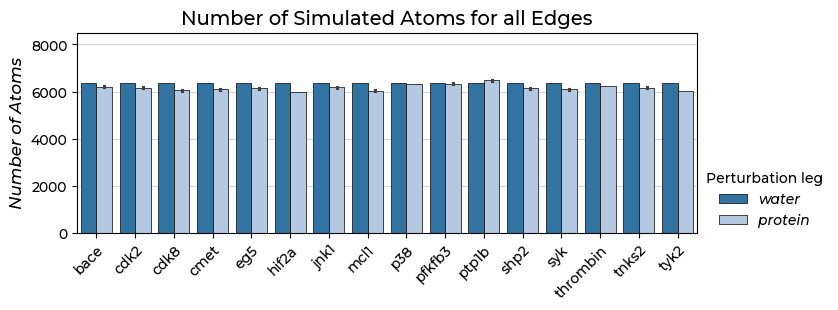

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyfonts import load_google_font

tick_font = load_google_font("Montserrat", weight=500)
label_font = load_google_font("Montserrat", weight=500, italic=True)
title_font = load_google_font("Montserrat", weight=500)


def set_font_properties(ax, tick_font=tick_font, label_font=label_font, title_font=title_font):
    ax.set_xlabel(ax.get_xlabel(), fontproperties=label_font, size=12)
    ax.set_ylabel(ax.get_ylabel(), fontproperties=label_font, size=12)
    ax.set_title(ax.get_title(), fontproperties=title_font, size=14)
    for label in ax.get_xticklabels():
        label.set_fontproperties(tick_font)
        label.set_fontsize(10)
    for label in ax.get_yticklabels():
        label.set_fontproperties(tick_font)
        label.set_fontsize(10)
    legend = ax.get_legend()
    if legend:
        # Update the font properties of the legend texts
        for text in legend.get_texts():
            text.set_fontproperties(label_font)
        # Optionally, update the font of the legend title if it exists
        if legend.get_title():
            legend.get_title().set_fontproperties(title_font)


palette = "tab20"
fig, ax = plt.subplots(figsize=(8, 2.6))

barplot = sns.barplot(
    df,
    hue="system",
    x="target",
    y="final_n_atoms",
    ax=ax,
    palette=palette,
    edgecolor="black",
    linewidth=0.5,
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    ha="right",
    rotation_mode="anchor",
    fontsize=9,
)

ax.set_title(
    r"Number of Simulated Atoms for all Edges",
)
ax.legend().set_visible(False)
ax.legend(
    bbox_to_anchor=(1.005, 0), loc="lower left", borderaxespad=0, frameon=False, title="Perturbation leg"
)

ax.set_ylabel("Number of Atoms")
ax.set_xlabel("")
ax.grid(axis="y", alpha=0.5)
ax.set_ylim(0, 8500)

ax.set_axisbelow(True)
plt.subplots_adjust(hspace=0.4)
set_font_properties(ax)
fig.savefig("../figures/system_sizes.svg", bbox_inches="tight")
fig.savefig("../figures/system_sizes.png", bbox_inches="tight", dpi=300, facecolor="white")
plt.show()

# Ligand sizes

In [27]:
import json
from QligFEP.pdb_utils import read_pdb_to_dataframe
import pandas as pd

rela_path = "../perturbations/{target}/1.water/"

results = []

for target in tqdm(all_targets):

    simulated_pdb = sorted(
        Path(rela_path.format(target=target)).resolve().glob("*/inputfiles/complexnotexcluded.pdb")
    )

    all_ligand_n_atoms = {}

    for _pdb in simulated_pdb:
        _config = json.loads((_pdb.parent / "fep_config.json").read_text())
        lig1, lig2 = _config["lig1"], _config["lig2"]

        df = read_pdb_to_dataframe(_pdb)
        fep_ligand_atoms = (
            df.query("residue_name.isin(['LIG', 'LID'])").groupby("residue_name").size().to_dict()
        )

        lig1_size = fep_ligand_atoms["LIG"]  # ligand 1 defaults to LIG, ligand 2 to LID in QligFEP
        lig2_size = fep_ligand_atoms["LID"]

        if lig1 not in all_ligand_n_atoms:
            all_ligand_n_atoms[lig1] = lig1_size
        else:
            if all_ligand_n_atoms[lig1] != lig1_size:
                raise ValueError("Ligands should have consistent number of atoms across all FEP edges.")
        if lig2 not in all_ligand_n_atoms:
            all_ligand_n_atoms[lig2] = lig2_size
        else:
            if all_ligand_n_atoms[lig2] != lig2_size:
                raise ValueError("Ligands should have consistent number of atoms across all FEP edges.")
        if target == "cdk8ManualMapping":
            target = "cdk8"
        results.append(
            pd.DataFrame.from_dict(all_ligand_n_atoms, orient="index", columns=["n_atoms"])
            .reset_index(names=["ligand_name"])
            .assign(target=target)
        )

results = pd.concat(results, ignore_index=True)

  0%|          | 0/16 [00:00<?, ?it/s]

/tmp/ipykernel_3665937/791958723.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  violinplot = sns.violinplot(
/tmp/ipykernel_3665937/791958723.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


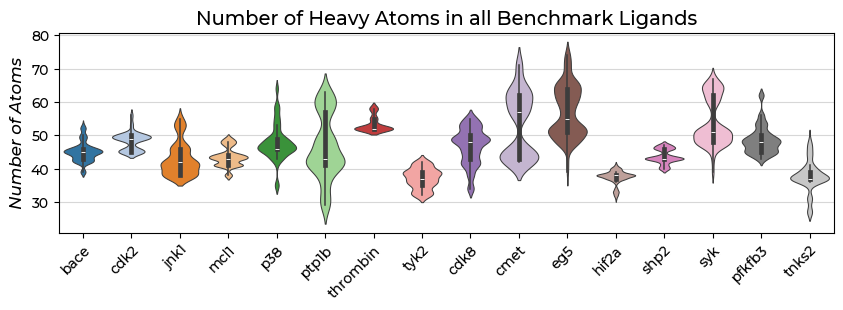

In [ ]:
palette = "tab20"
fig, ax = plt.subplots(figsize=(8, 2.6))

violinplot = sns.violinplot(
    results,
    x="target",
    y="n_atoms",
    ax=ax,
    palette=palette,
    # edgecolor="black",
    linewidth=0.75,
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    ha="right",
    rotation_mode="anchor",
    fontsize=9,
)

ax.set_title(
    "Number of Heavy Atoms in all Benchmark Ligands",
)
ax.set_ylabel("Number of Atoms")
ax.set_xlabel("")
ax.grid(axis="y", alpha=0.5)

ax.set_axisbelow(True)
plt.subplots_adjust(hspace=0.4)
set_font_properties(ax)
fig.savefig("../figures/ligand_sizes.svg", bbox_inches="tight")
fig.savefig("../figures/ligand_sizes.png", bbox_inches="tight", dpi=300, facecolor="white")
plt.show()